# Yelp dataset

In [ ]:
!pip install 'transformers[torch]'

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install pyspark

In [ ]:
!pip install matplotlib

In [ ]:
!pip install matplotlib seaborn

In [ ]:
# Import PyTorch
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Import PySpark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import date_format

import os
import glob
import pandas as pd

import matplotlib.pyplot as plt

In [ ]:
import seaborn as sns

In [ ]:
# initialize PySpark
spark = SparkSession.builder \
    .appName("BERT4Loc") \
    .getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.listdir("/content/drive/My Drive/Yelp_data/yelp_parquet")

In [ ]:
business = spark.read.parquet("/content/drive/My Drive/Yelp_data/yelp_parquet/yelp_academic_dataset_business.parquet")
user = spark.read.parquet("/content/drive/My Drive/Yelp_data/yelp_parquet/yelp_academic_dataset_user.parquet")
checkin = spark.read.parquet("/content/drive/My Drive/Yelp_data/yelp_parquet/yelp_academic_dataset_checkin.parquet")
tip = spark.read.parquet("/content/drive/My Drive/Yelp_data/yelp_parquet/yelp_academic_dataset_tip.parquet")
review = spark.read.parquet("/content/drive/My Drive/Yelp_data/yelp_parquet/yelp_academic_dataset_review.parquet")

In [ ]:
# Table Dimensions
print("Business")
print("Number of columns: ",len(business.columns) , " and number of rows: ", business.count(), "\n")

print("User")
print("Number of columns: ",len(user.columns) , " and number of rows: ", user.count(), "\n")

print("CheckIn")
print("Number of columns: ",len(checkin.columns) , " and number of rows: ", checkin.count(), "\n")

print("Tip")
print("Number of columns: ",len(tip.columns) , " and number of rows: ", tip.count(), "\n")

print("Review")
print("Number of columns: ",len(review.columns) , " and number of rows: ", review.count(), "\n")

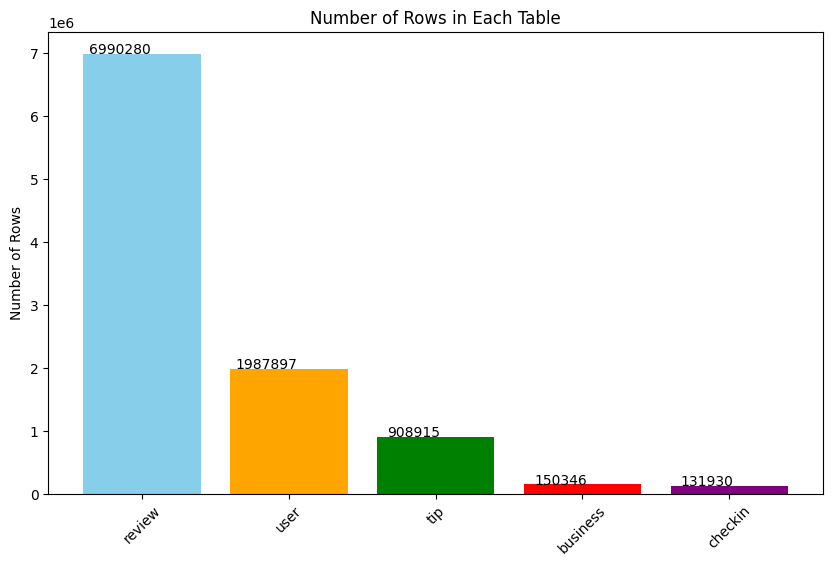

In [ ]:
tables = ['business', 'user', 'checkin', 'tip', 'review']
rows_counts = [business.count(), user.count(), checkin.count(), tip.count(), review.count()]
column_counts = [len(business.columns), len(user.columns), len(checkin.columns), len(tip.columns), len(review.columns)]

sorted_indices = sorted(range(len(rows_counts)), key=lambda k: rows_counts[k], reverse=True)
sorted_tables = [tables[i] for i in sorted_indices]
sorted_rows_counts = [rows_counts[i] for i in sorted_indices]

# Define custom colors for the bars
colors = ['skyblue', 'orange', 'green', 'red', 'purple']

plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_tables, sorted_rows_counts, color=colors)

# Display row counts above the bars
for bar, count in zip(bars, sorted_rows_counts):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.05, str(count), ha='center')

plt.xlabel('')
plt.ylabel('Number of Rows')
plt.title('Number of Rows in Each Table')

plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

## EDA and Pre Processing


In [ ]:
from pyspark.sql.functions import col

# Filter out businesses that are open (is_open = 1)
open_businesses = business.filter(col("is_open") == 1)

# Group open businesses by their open status and count them
open_business_counts = open_businesses.groupBy("is_open").count()

# Show the result
open_business_counts.show()

+-------+------+
|is_open| count|
+-------+------+
|      1|119698|
+-------+------+



In [ ]:
open_businesses.show()

+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|          city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|87 Grasso Plaza S...|{NULL, NULL, NULL...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|        Affton|{8:0-18:30, 0:0-0...|      1|    38.551126|    -90.335695|       The UPS Store|      63123|          15|  3.0|   MO|
|         935 Race St|{NULL, NULL, u'no...|MTSW4McQd7CbVtyjq...|Restaurants, Food...|  Philadelphia|{7:0-21:0, 7:0-20...|      1|   

In [ ]:
name_count = open_businesses.groupBy("name").count().orderBy(F.col("count").desc())
name_count.show()

In [ ]:
name_count_pd = name_count.toPandas()

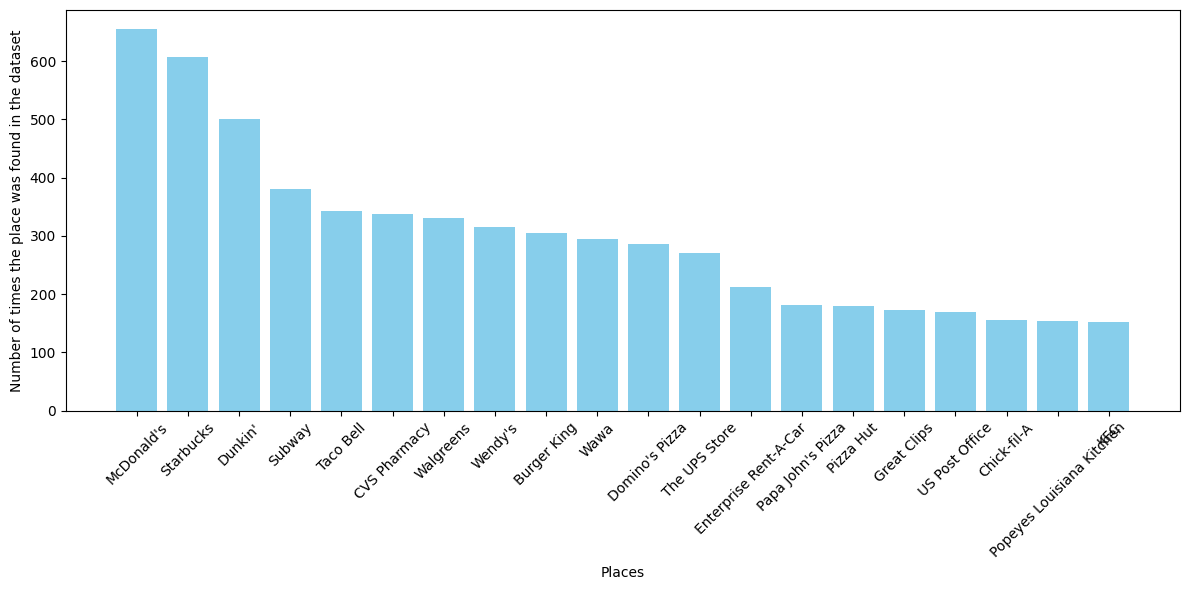

In [ ]:
# Select only the first 20 rows
name_count_subset = name_count_pd.head(20)

# Plot using Matplotlib
plt.figure(figsize=(12, 6))
plt.bar(name_count_subset['name'], name_count_subset['count'], color='skyblue')
plt.xlabel('Places')
plt.ylabel('Number of times the place was found in the dataset')
plt.title('')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

In [ ]:
state_count = open_businesses.groupBy("state").count().orderBy(F.col("count").desc())
state_count.show()

In [ ]:
state_count_pd = state_count.toPandas()

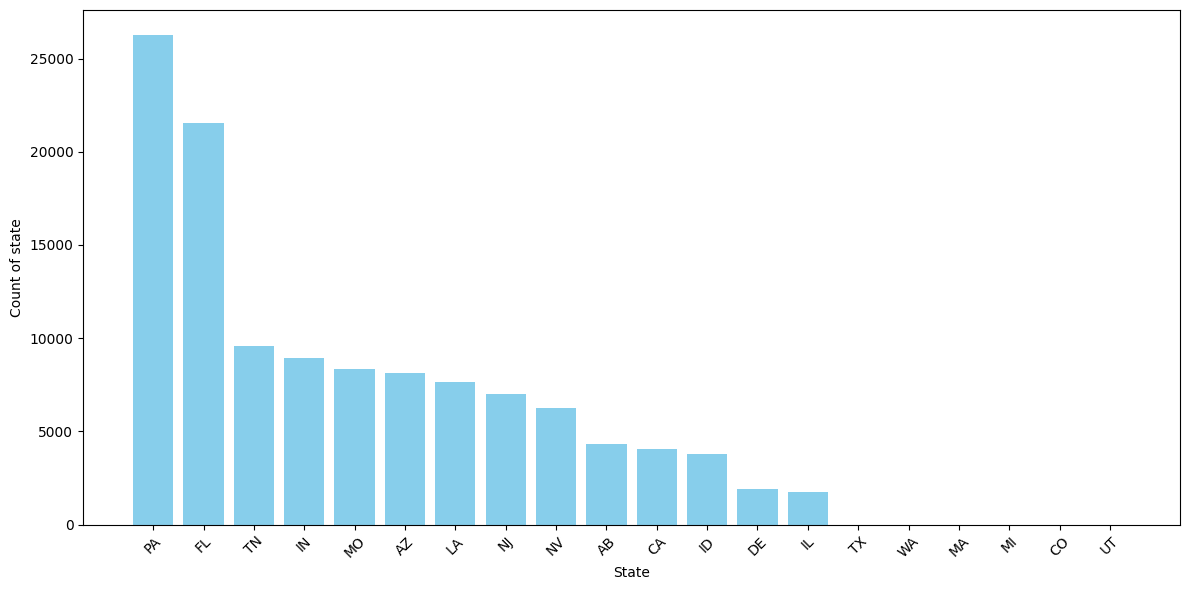

In [ ]:
# Select only the first 20 rows
state_count_subset = state_count_pd.head(20)

# Plot using Matplotlib
plt.figure(figsize=(12, 6))
plt.bar(state_count_subset['state'], state_count_subset['count'], color='skyblue')
plt.xlabel('State')
plt.ylabel('Count of state')
plt.title('')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

In [ ]:
# Step 1: Extract the category column
categories_column = open_businesses.select("categories")

# Step 2: Break down the list of categories
# Assuming that the categories are separated by commas in the "categories" column
categories_separated = categories_column.withColumn("category", F.explode(F.split("categories", ", ")))

# Step 3: Count the unique categories
category_count = categories_separated.groupBy("category").count().orderBy("count", ascending=False)

# Show unique categories and their count
category_count.show()

In [ ]:
category_count_pd = category_count.toPandas()

In [ ]:
category_count_subset = category_count_pd.head(20)

# Plot using Matplotlib
plt.figure(figsize=(12, 6))
plt.bar(category_count_subset['category'], category_count_subset['count'], color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count of category')
plt.title('')
plt.xticks(rotation=60)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

## Review Threshold


Businesses that have a review threshold will be filtered, in order to guarantee the quality of the data. For this, the number of reviews that each business has is calculated, using the `business_id`, and later, the distribution of the number of reviews is reviewed.

In [ ]:
review_counts = review.join(open_businesses, "business_id", "inner") \
                     .groupBy(open_businesses["business_id"]) \
                     .agg(F.count("review_id").alias("num_reviews"))

# Show the result
review_counts.show()

+--------------------+-----------+
|         business_id|num_reviews|
+--------------------+-----------+
|Q9G2gtnVDZgsNerHD...|         49|
|OTfoTKlO8ZlLifPh9...|         37|
|wgEST8dD-vPpn-6MC...|        159|
|D88YfiD-nAVRJDkex...|         28|
|bYZaftBLgjlKqCCBE...|         54|
|r3X75SK37buS94mDl...|        286|
|TZXerCtmzNNSnOZ4I...|         19|
|oQ0MQpVVyzGe_JTIL...|         46|
|EWPWK3aLsBRfXjeW7...|        114|
|aWbKnO5GiIXIn1wyr...|         30|
|PNby7mawC0ecfg-uE...|        153|
|CBrD7r4PTCAKc7sP_...|        190|
|nrFmQUHZQVCsrg1mu...|        219|
|LgHYTrrRhajfo4y8j...|         54|
|3WqM_1p-n1Wy0Ev4R...|         12|
|pIC2xqIGVJREbyBe0...|          9|
|di16IFrhgvaK1W2IF...|        148|
|7Z1nSSjJFUYge0Ru5...|          7|
|6on3h8WZ3mFLvpAVk...|         20|
|MGZaaEL7xTl-odwsO...|          8|
+--------------------+-----------+
only showing top 20 rows



In [ ]:
review_counts_pandas = review_counts.toPandas()

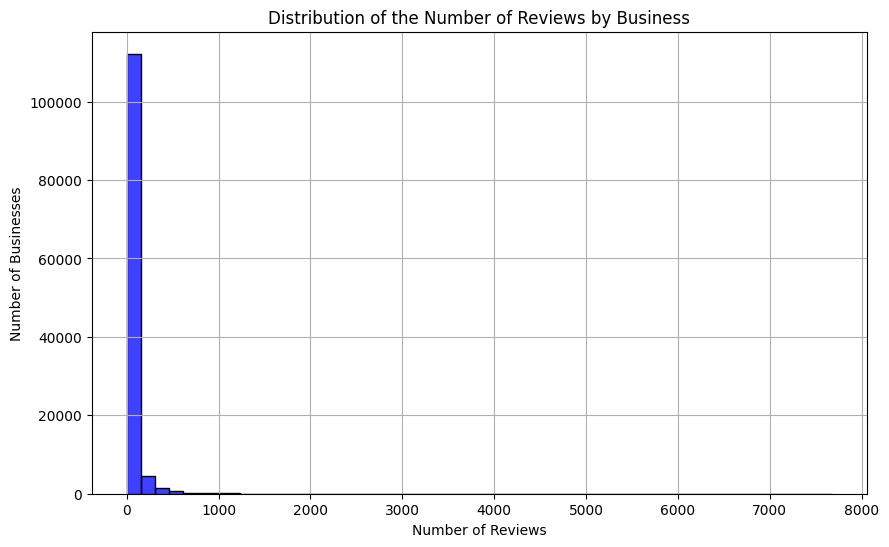

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(review_counts_pandas['num_reviews'], bins=50, kde=False, color='blue')
plt.title('Distribution of the Number of Reviews by Business')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Businesses')
plt.grid(True)
plt.show()

In [ ]:
review_counts_pandas["num_reviews"].quantile([.25, .5, .75])

0.25     8.0
0.50    15.0
0.75    38.0
Name: num_reviews, dtype: float64

In [ ]:
import numpy as np
import scipy.stats as stats


1. Q1 (25. percentil): 25% podataka ima manje ili jednako od 8 recenzija.

2. Q2 ili medijan (50. percentil): 50% podataka ima manje ili jednako od 15 recenzija.

3. Q3 (75. percentil): 75% podataka ima manje ili jednako od 38 recenzija.

Ovi kvantili koriste se za opisivanje raspodjele podataka. Na primjer, 25% podataka nalazi se ispod vrijednosti Q1 (8 recenzija ili manje), dok 75% podataka nalazi se ispod vrijednosti Q3 (38 recenzija ili manje). Medijan (
Q2) predstavlja srednju vrijednost podataka, gdje je 50% podataka manje ili jednako od 15 recenzija. Ovi kvantili korisni su za razumijevanje raspona i koncentracije vrijednosti u distribuciji "num_reviews".

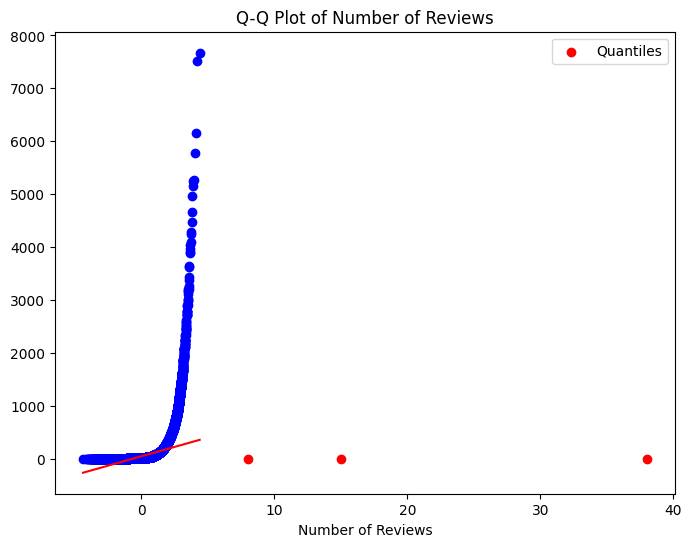

In [ ]:
# Calculate the quantiles
quantiles = review_counts_pandas["num_reviews"].quantile([0.25, 0.5, 0.75])

# Generate samples from a Gaussian distribution with the same mean and standard deviation
mean = review_counts_pandas["num_reviews"].mean()
std_dev = review_counts_pandas["num_reviews"].std()
gaussian_samples = np.random.normal(mean, std_dev, len(review_counts_pandas))

# Create Q-Q plot
plt.figure(figsize=(8, 6))
stats.probplot(review_counts_pandas["num_reviews"], dist="norm", plot=plt)
plt.scatter(quantiles, stats.norm.ppf([0.25, 0.5, 0.75]), color='red', label='Quantiles', zorder=5)
plt.xlabel('Number of Reviews')
plt.ylabel('')
plt.title('Q-Q Plot of Number of Reviews')
plt.legend()
plt.show()

In [ ]:
user_averages_stars = user.groupBy("average_stars").agg(F.count("user_id").alias("num_average_stars"))
user_averages_stars.show()

+-------------+-----------------+
|average_stars|num_average_stars|
+-------------+-----------------+
|         2.86|             3088|
|         3.26|             1766|
|         1.82|              300|
|         4.19|             4165|
|          2.4|             3049|
|         2.82|             1572|
|         2.41|              456|
|         1.41|               44|
|         2.62|              797|
|         4.88|             3416|
|         4.92|             1770|
|         3.02|              600|
|         4.23|             4157|
|         2.55|              952|
|         1.42|              111|
|         4.02|             2583|
|         1.31|              126|
|         4.36|             5107|
|         3.08|             2293|
|         3.57|             6430|
+-------------+-----------------+
only showing top 20 rows



## Applying Filters

In [ ]:
checkin.show()

+--------------------+--------------------+
|         business_id|                date|
+--------------------+--------------------+
|SGiSLM8r8rT3oWa6q...|2012-12-16 23:08:...|
|SGigkw0zqh4TTXfer...|2011-12-18 18:13:...|
|SGjX-JihpCo8IHGfJ...|2012-02-04 00:33:...|
|SGk0C8RrR7sPKYq2Z...|2012-11-11 22:46:...|
|SGlFcy13cDajEQ_ci...|2012-02-23 18:36:...|
|SGnyNlTPm_u3EGHEW...|2011-11-13 06:17:...|
|SGp9Bg7Y2UCErFMGn...|2014-01-19 01:03:...|
|SGq1InSo0N0hK5PHu...|2018-03-24 19:49:...|
|SGqFldAEiAl0EcCmp...|2010-07-20 02:10:...|
|SGr_cAWLSMUwTbOc4...|2015-09-11 19:55:...|
|SGrknTSdt7p4e0Uqw...|2012-05-18 21:13:...|
|SGsidlOaky7Piw7rQ...| 2020-02-14 17:39:16|
|SGtB-yzWcFn0laOGa...|2010-06-08 01:12:...|
|SGviib24zUAlP-DgL...|2015-09-29 01:56:...|
|SH5tXNJsabzU37YSd...|2021-01-23 19:00:...|
|SH8jvBEq_Jh2d_rIa...|2017-01-25 19:11:...|
|SHD2peHqzir1Q6QNy...|2017-07-18 15:50:...|
|SHDLYf_m1aqPHcTCY...|2012-08-03 22:58:...|
|SHHn2sz0_d188bEV3...|2015-07-24 15:08:...|
|SHMaxSrTwnAKEGPHt...|2012-12-24

In [ ]:
business_id_more_reviews = review_counts.filter(review_counts.num_reviews > 15)
business_id_more_reviews.show()

+--------------------+-----------+
|         business_id|num_reviews|
+--------------------+-----------+
|Q9G2gtnVDZgsNerHD...|         49|
|OTfoTKlO8ZlLifPh9...|         37|
|wgEST8dD-vPpn-6MC...|        159|
|D88YfiD-nAVRJDkex...|         28|
|bYZaftBLgjlKqCCBE...|         54|
|r3X75SK37buS94mDl...|        286|
|TZXerCtmzNNSnOZ4I...|         19|
|oQ0MQpVVyzGe_JTIL...|         46|
|EWPWK3aLsBRfXjeW7...|        114|
|aWbKnO5GiIXIn1wyr...|         30|
|PNby7mawC0ecfg-uE...|        153|
|CBrD7r4PTCAKc7sP_...|        190|
|nrFmQUHZQVCsrg1mu...|        219|
|LgHYTrrRhajfo4y8j...|         54|
|di16IFrhgvaK1W2IF...|        148|
|6on3h8WZ3mFLvpAVk...|         20|
|__rP5Fy4peONwyjcm...|         35|
|bPoU-QnlvgbTZWqsE...|         37|
|2yKHpLLUFd2Hv0l5_...|         46|
|aKJOFpR1Gd4DYP4Sa...|         80|
+--------------------+-----------+
only showing top 20 rows



In [ ]:
business2 = business.join(business_id_more_reviews, "business_id", "inner")
review2 = review.join(business_id_more_reviews, "business_id", "inner")
checkin2 = checkin.join(business_id_more_reviews, "business_id", "inner")
tip2 = tip.join(business_id_more_reviews, "business_id", "inner")

In [ ]:
print("Number of rows of business2: ", business2.count(), "| Number of rows of business: ", business.count())
print("Number of rows of review2: ", review2.count(), "| Number of rows of review: ", review.count())
print("Number of rows of checkin2: ", checkin2.count(), "| Number of rows of checkin: ", checkin.count())
print("Number of rows of tip2: ", tip2.count(), "| Number of rows of tip: ", tip.count())

Number of rows of business2:  59045 | Number of rows of business:  150346
Number of rows of review2:  5267999 | Number of rows of review:  6990280
Number of rows of checkin2:  56798 | Number of rows of checkin:  131930
Number of rows of tip2:  653408 | Number of rows of tip:  908915


In [ ]:
review2 = review2.withColumn("truncated_date", date_format("date", "yyyy-MM-dd"))

In [ ]:
# Group by truncated date and count the number of reviews
review_date_count = review2.groupBy("truncated_date").agg(F.count("review_id").alias("review_count"))

# Sort by number of reviews in descending order
review_date_count = review_date_count.sort("review_count", ascending=False)

review_date_count.approxQuantile("review_count", [.25, .5, .75], 0)
# Filter dates with more than 971 reviews
high_flow_dates = review_date_count.filter("review_count > 971")

# Get a list of dates with high flow of reviews
high_flow_date_list = [row.truncated_date for row in high_flow_dates.select("truncated_date").collect()]
# Filter the review table to include only dates with a high flow of reviews
filtered_date_review = review2.filter(review2.truncated_date.isin(high_flow_date_list))

In [ ]:
def check_duplicate_ids(df, id_column):
    duplicate_ids = df.groupBy(id_column).count().filter(F.col("count") > 1)
    if duplicate_ids.count() > 0:
        print(f"Duplicate IDs found in column {id_column}:")
        duplicate_ids.show()
    else:
        print(f"No duplicate IDs found in the column {id_column}.")

In [ ]:
check_duplicate_ids(business2, "business_id")

No duplicate IDs found in the column business_id.


In [ ]:
check_duplicate_ids(review2, "review_id")

No duplicate IDs found in the column review_id.


In [ ]:
user2 = user.filter(user.review_count >= 5)

In [ ]:
check_duplicate_ids(user2, "user_id")

No duplicate IDs found in the column user_id.


In [ ]:
joined_df = business2.select(
    F.col("business_id"),
    F.col("name").alias("business.name"),
    F.col("latitude").alias("business.latitude"),
    F.col("longitude").alias("business.longitude"),
    F.col("stars").alias("business.stars"),
    F.col("review_count").alias("business.review_count"),
    F.col("categories").alias("business.categories"),
    F.col("address").alias("bussines.address"),
    F.col("city").alias("bussines.city"),
    F.col("name").alias("bussines.name"),
    F.col("state").alias("bussines.state")

).join(
    review2.select(
        F.col("review_id"),
        F.col("user_id"),
        F.col("business_id"),
        F.col("stars").alias("review.stars"),
        F.col("date").alias("review.date"),
        F.col("text").alias("review.text"),
        F.col("useful").alias("review.useful")

    ),
    "business_id",
    "inner"
)

In [ ]:
joined_df = joined_df.join(
    user2.select(F.col("user_id"),
                 F.col("review_count").alias("user.review_count"),
                 F.col("average_stars").alias("user.average_stars"),
                 F.col("useful").alias("user.useful"),
                 F.col("fans").alias("user.fans"),
                 F.col("compliment_hot").alias("user.compliment_hot")
                 ),
    'user_id',
    "inner"
    )

In [ ]:
joined_df.head()

Row(user_id='--Kwhcbkh7jxkhVVQZo2uQ', business_id='Ld805G25xHALqbBo1Sypbg', business.name='National Blues Museum', business.latitude=38.630434, business.longitude=-90.1894902, business.stars=4.5, business.review_count=45, business.categories='Arts & Entertainment, Music Venues, Venues & Event Spaces, Nightlife, Museums, Event Planning & Services', bussines.address='615 Washington Ave', bussines.city='Saint Louis', bussines.name='National Blues Museum', bussines.state='MO', review_id='FoiFi2X684BwaYuYDnqBvw', review.stars=3.0, review.date='2019-11-11 03:51:53', review.text="It was okay. If you don't know anything about any blues history, it is well worth the visit.\n\nIt was almost all pictures and paragraphs on walls. There wasn't much to actually look at in terms of records, instruments, or memorabilia. Yes, there were a few 78s, 45s, and some early cylinders. A wall of a few hundred harmonicas was a point of interest.\n\nThe biggest draw for me was the Chuck Berry exhibit. There was 

In [ ]:
joined_df.show()

+--------------------+--------------------+--------------------+-----------------+------------------+--------------+---------------------+--------------------+--------------------+--------------+--------------------+--------------+--------------------+------------+-------------------+--------------------+-------------+-----------------+------------------+-----------+---------+-------------------+
|             user_id|         business_id|       business.name|business.latitude|business.longitude|business.stars|business.review_count| business.categories|    bussines.address| bussines.city|       bussines.name|bussines.state|           review_id|review.stars|        review.date|         review.text|review.useful|user.review_count|user.average_stars|user.useful|user.fans|user.compliment_hot|
+--------------------+--------------------+--------------------+-----------------+------------------+--------------+---------------------+--------------------+--------------------+--------------+-----

In [ ]:
# joined_df.write.parquet("/content/drive/My Drive/Yelp_data/yelp_parquet/joined_df.parquet", mode='overwrite')


In [ ]:
# we divide the dataframe into train and test, 80% train and 20% test, and save the data
train_df, test_df = joined_df.randomSplit([0.8, 0.2])
# train_df.write.parquet("/content/drive/My Drive/Yelp_data/yelp_parquet/train_df.parquet", mode='overwrite')
# test_df.write.parquet("/content/drive/My Drive/Yelp_data/yelp_parquet/test_df.parquet", mode='overwrite')

In [ ]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
from torch.cuda.amp import autocast, GradScaler
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error

import numpy as np
import pickle
import json
from sklearn.metrics import accuracy_score
import pandas as pd
import re
import os


In [ ]:
train_df.show()

+--------------------+--------------------+--------------------+-----------------+------------------+--------------+---------------------+--------------------+--------------------+--------------+--------------------+--------------+--------------------+------------+-------------------+--------------------+-------------+-----------------+------------------+-----------+---------+-------------------+
|             user_id|         business_id|       business.name|business.latitude|business.longitude|business.stars|business.review_count| business.categories|    bussines.address| bussines.city|       bussines.name|bussines.state|           review_id|review.stars|        review.date|         review.text|review.useful|user.review_count|user.average_stars|user.useful|user.fans|user.compliment_hot|
+--------------------+--------------------+--------------------+-----------------+------------------+--------------+---------------------+--------------------+--------------------+--------------+-----

In [ ]:
test_df = pd.read_parquet("/content/drive/My Drive/Yelp_data/yelp_parquet/test_df.parquet")
train_df = pd.read_parquet("/content/drive/My Drive/Yelp_data/yelp_parquet/train_df.parquet")

In [ ]:
def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text).lower()


def truncated_text(text):
    if len(text.split()) > 200:
        return " ".join(text.split()[0:200])
    else:
        return text

In [ ]:
test_df.head(5)

,user_id,business_id,business.name,business.latitude,business.longitude,business.stars,business.review_count,business.categories,bussines.address,bussines.city,...,review_id,review.stars,review.date,review.text,review.useful,user.review_count,user.average_stars,user.useful,user.fans,user.compliment_hot
0,--Kwhcbkh7jxkhVVQZo2uQ,ORL4JE6tz3rJxVqkdKfegA,Gaylord Opryland Resort & Convention Center,36.211592,-86.694319,3.0,1639,"Venues & Event Spaces, Performing Arts, Arts &...",2800 Opryland Dr,Nashville,...,bSz0fCiKRJAB0qI9lB519A,4.0,2014-09-07 16:22:03,The place is absolutely huge! That's the attra...,0,58,3.62,57,2,0
1,--Kwhcbkh7jxkhVVQZo2uQ,tIvfmgT1qMeAEQf8CI5fPQ,Caney Fork River Valley Grille,36.217523,-86.696733,3.5,574,"Bars, Nightlife, American (Traditional), Barbe...",2400 Music Valley Dr,Nashville,...,G4YEeMu4Sj1XUEmlJwGe4A,4.0,2014-09-06 01:09:35,Ate dinner there tonight. Service was pretty f...,1,58,3.62,57,2,0
2,--bAnPT8W3L01Rg17js-Zw,Rf0DVg3MyX-MWokFZuaftA,Shogun Japanese Steak & Sushi,35.969591,-86.805511,3.0,155,"Japanese, Restaurants",1638 Westgate Cir,Brentwood,...,YOCkeRFab1774tSVtF6Ciw,5.0,2019-08-23 04:18:29,Omgggggg Chef Joeeee is so awesome he really p...,1,6,2.33,5,0,0
3,--llVTFQ8D8zcja9NH5-cA,GiBzgOOkfr-Ec_h-2TrcSw,"Chateau LeMoyne - French Quarter, A Holiday In...",29.956309,-90.069323,3.5,191,"Hotels, Event Planning & Services, Hotels & Tr...",301 Dauphine St,New Orleans,...,dX58RYFBiqvnKQXwG0175w,5.0,2019-07-18 05:03:27,Super cute and very comfortable boutique hotel...,1,28,4.74,19,1,0
4,-0EzgKMI9ZakqLiWR8f9hQ,6aPXOXi8h1m58hihgi2dvw,Old Northeast Pizza,27.779712,-82.635753,4.0,112,"Pizza, Restaurants, Sandwiches",718 2nd St N,St. Petersburg,...,C74fnh5gpnH2cgbHTIAP3g,5.0,2018-07-18 13:04:59,If you're looking for real New York-style pizz...,0,5,5.00,1,0,0


# Label Encoder i Dropovanje nepotrebnih kolona

In [ ]:
from sklearn.preprocessing import LabelEncoder
user_label_encoder = LabelEncoder()
user_num_ids = user_label_encoder.fit_transform(test_df['user_id'])
test_df['user_num_id'] = user_num_ids

In [ ]:
business_label_encoder = LabelEncoder()
business_num_ids = business_label_encoder.fit_transform(test_df['business_id'])
test_df['business_num_id'] = business_num_ids

In [ ]:
test_df.head()

,user_id,business_id,business.name,business.latitude,business.longitude,business.stars,business.review_count,business.categories,bussines.address,bussines.city,...,review.text,review.useful,user.review_count,user.average_stars,user.useful,user.fans,user.compliment_hot,category_ids,user_num_id,business_num_id
0,--Kwhcbkh7jxkhVVQZo2uQ,ORL4JE6tz3rJxVqkdKfegA,Gaylord Opryland Resort & Convention Center,36.211592,-86.694319,3.0,1639,"Venues & Event Spaces, Performing Arts, Arts &...",2800 Opryland Dr,Nashville,...,The place is absolutely huge! That's the attra...,0,58,3.62,57,2,0,31,31,23062
1,--Kwhcbkh7jxkhVVQZo2uQ,tIvfmgT1qMeAEQf8CI5fPQ,Caney Fork River Valley Grille,36.217523,-86.696733,3.5,574,"Bars, Nightlife, American (Traditional), Barbe...",2400 Music Valley Dr,Nashville,...,Ate dinner there tonight. Service was pretty f...,1,58,3.62,57,2,0,31,31,51925
2,--bAnPT8W3L01Rg17js-Zw,Rf0DVg3MyX-MWokFZuaftA,Shogun Japanese Steak & Sushi,35.969591,-86.805511,3.0,155,"Japanese, Restaurants",1638 Westgate Cir,Brentwood,...,Omgggggg Chef Joeeee is so awesome he really p...,1,6,2.33,5,0,0,57,57,26012
3,--llVTFQ8D8zcja9NH5-cA,GiBzgOOkfr-Ec_h-2TrcSw,"Chateau LeMoyne - French Quarter, A Holiday In...",29.956309,-90.069323,3.5,191,"Hotels, Event Planning & Services, Hotels & Tr...",301 Dauphine St,New Orleans,...,Super cute and very comfortable boutique hotel...,1,28,4.74,19,1,0,75,75,16128
4,-0EzgKMI9ZakqLiWR8f9hQ,6aPXOXi8h1m58hihgi2dvw,Old Northeast Pizza,27.779712,-82.635753,4.0,112,"Pizza, Restaurants, Sandwiches",718 2nd St N,St. Petersburg,...,If you're looking for real New York-style pizz...,0,5,5.00,1,0,0,132,132,6977


In [ ]:
test_df.drop_duplicates(subset='business_num_id', keep='first', inplace=True)
test_df.drop_duplicates(subset='user_num_id', keep='first', inplace=True)

test_df.head()

In [ ]:
test_df.drop(['user_id', 'business_id'], axis=1, inplace=True)

In [ ]:
test_df

In [ ]:
bus_cat_label_encoder = LabelEncoder()
bus_cat_num_ids = business_label_encoder.fit_transform(test_df['business.categories'])
test_df['bus_cat_num_id'] = bus_cat_num_ids

In [ ]:
test_df

In [ ]:
test_df.drop([
    'business.longitude',
    'business.latitude',
    'business.categories',
    'category_ids'
 ], axis = 1, inplace = True)

In [ ]:
test_df.head()

In [ ]:
test_df.drop(['bussines.address', 'business.name', 'bussines.name', 'user.compliment_hot', 'review.useful', 'review.date'], axis=1, inplace=True)

In [ ]:
test_df.head()

In [ ]:
review_label_encoder = LabelEncoder()
review_num_ids = review_label_encoder.fit_transform(test_df['review_id'])
test_df['review_num_id'] = review_num_ids

In [ ]:
bus_city_label_encoder = LabelEncoder()
bus_city_num_ids = bus_city_label_encoder.fit_transform(test_df['bussines.city'])
test_df['business_city_id'] = bus_city_num_ids

In [ ]:
test_df.drop(['bussines.state'], axis = 1, inplace=True)

In [ ]:
test_df.drop(['bussines.city', 'review_id'], axis = 1, inplace=True)

In [ ]:
test_df.head()

,business.stars,business.review_count,review.stars,review.text,user.review_count,user.average_stars,user.useful,user.fans,user_num_id,business_num_id,bus_cat_num_id,review_num_id,business_city_id
0,3.0,1639,4.0,The place is absolutely huge! That's the attra...,58,3.62,57,2,31,23062,26139,25268,471
2,3.0,155,5.0,Omgggggg Chef Joeeee is so awesome he really p...,6,2.33,5,0,57,26012,14563,22600,64
3,3.5,191,5.0,Super cute and very comfortable boutique hotel...,28,4.74,19,1,75,16128,13972,26528,477
4,4.0,112,5.0,If you're looking for real New York-style pizz...,5,5.00,1,0,132,6977,18881,8501,679
5,3.5,11,5.0,My experience with broadstone has been excepti...,9,4.08,7,0,232,31153,1325,1868,702


In [ ]:
X = test_df[['business_city_id', 'review_num_id', 'bus_cat_num_id', 'business.review_count',
       'user.review_count', 'user.average_stars', 'user.useful', 'user.fans', 'user_num_id']]
Y = test_df['business.stars']

In [ ]:
train_set, test_set = train_test_split(test_df, test_size = 0.2, random_state = 42)

X_train = X[:-100]
X_test = X[-100:]

Y_train = Y[:-100]
Y_test = Y[-100:]

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

linear_reg = LinearRegression()
linear_reg.fit(X_train, Y_train)

Y_predict = linear_reg.predict(X_test)

mse = mean_squared_error(Y_test, Y_predict)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test, Y_predict)
r2 = r2_score(Y_test, Y_predict)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r2)


Mean Squared Error: 0.7581775840256241
Root Mean Squared Error: 0.8707339341185826
Mean Absolute Error: 0.7045287577500244
R-squared Score: 0.0957073854586935


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linear_reg = LinearRegression()
linear_reg.fit(X_train, Y_train)

Y_predict = linear_reg.predict(X_test)
mse = mean_squared_error(Y_test, Y_predict)

print("Mean Squared Error:", mse)


Mean Squared Error: 0.7581775840256241


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create and train the Linear Regression model
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

# Predictions
predicted = regressor.predict(X_test)

# Calculate Mean Squared Error (MSE) for regression evaluation
mse = mean_squared_error(Y_test, predicted)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.7581775840256241


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

# Create and train the Gaussian Naive Bayes model
model = GaussianNB()
model.fit(X_train, Y_train)

# Predictions
predicted = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(Y_test, predicted)
print("Accuracy: {:.3f}".format(accuracy))

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, predicted)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(Y_test, predicted)
print("Classification Report:")
print(class_report)

# ROC-AUC Score and ROC Curve (for binary classification)
if len(set(Y_test)) == 2:
    prob_scores = model.predict_proba(X_test)[:, 1]  # Probabilities of the positive class
    roc_auc = roc_auc_score(Y_test, prob_scores)
    print("ROC-AUC Score: {:.3f}".format(roc_auc))

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(Y_test, prob_scores)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
else:
    print("ROC-AUC Score and ROC Curve are applicable for binary classification only.")


ValueError: ignored

In [ ]:
print(set(Y_train))


{1.5, 2.5, 3.5, 4.0, 5.0, 4.5, 3.0, 2.0, 1.0}
